# Starlet Tutorial: Modeling a Low Surface Brightness Galaxy

This tutorial goes through a case where the default `ExtendedSource` models will struggle: a complex low surface brightness galaxy.

### A word on starlets

Starlets have the flexibility to represent any pixelated 2-D profile. We take advantage of this property and use starlets to model sources with features that are too complex to be modeled with only assumptions of symmetry or monotonicity, such as irregular galaxies and spiral galaxies.

But first, the usual incantation:

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import astropy.io.fits as fits
import sep 
import pickle

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a superior colormap and don't interpolate the pixels
matplotlib.rc('image', interpolation='none', origin="lower")

## Load and Display Data

We load the data set (an image cube with 5 bands).

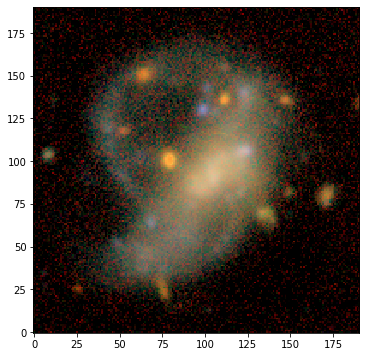

In [2]:
# Load the sample images
data = pickle.load(open("../../data/lsbg.pkl", "rb"))
images = data["images"]
filters = data["channels"]
psf = data["psfs"]

from scarlet.display import AsinhMapping

stretch = 1
Q = 5
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.figure(figsize = (6,6))
plt.imshow(img_rgb)
plt.show()

### Define Model Frame and Observation

With this we can fully specify the `Frame` and `Observation`:

In [3]:
model_psf = scarlet.GaussianPSF(sigma = 0.8)

model_frame = scarlet.Frame(
    images.shape,
    psf=model_psf,
    channels=filters)

observation = scarlet.Observation(
    images, 
    psf=scarlet.ImagePSF(psf),
    channels=filters).match(model_frame)

### Detection Catalog

Because we don't have a detection catalog, we need to build one. To avoid issues with merging peaks from different scales and false peaks at the lowest scale, we use the second scale for detection. We could use `detect = scarlet.detect.get_detect_wavelets(images, variance=0.1, scales=3)` to build a single band detection image, but we expand that method here to illustrate how to use starlet transforms in scarlet.

In [4]:
# Create a detection image by summing the images in all bands
# (a more rigorous approach would be to create a chi^2 coadd).
detect_image = np.sum(images, axis=0)
# Define a rough standard deviation for the image.
# This does not have to be exact, as it is fit by the
# get_multiresolution_support algorithm below.
sigma = 0.1
# Find the wavelet coefficients
coeffs = scarlet.wavelet.starlet_transform(detect_image, scales=3)
# Determine the significant coefficients
# (as defined in Starck et. al 2011)
M = scarlet.wavelet.get_multiresolution_support(detect_image, coeffs, sigma, K=3, epsilon=1e-1, max_iter=20)
# Use the multi-resolution support to select only
# the relevant pixels for detection
detect = M * coeffs
# We are only detecting positive peaks, so there
# is no need to include the negative coefficients
detect[detect<0] = 0

We created two different sets of wavelet coefficents above. The first is the set of wavelet coeffiecients in the first three scales (and the residual image with lower frequency flux) and second is only those coefficients that are determined to be "significant" according to the algorithm in Starck et al. 2011.

Below we view both sets of coefficents, and compare the reconstruction of the full set of wavelet coefficients with the input image.

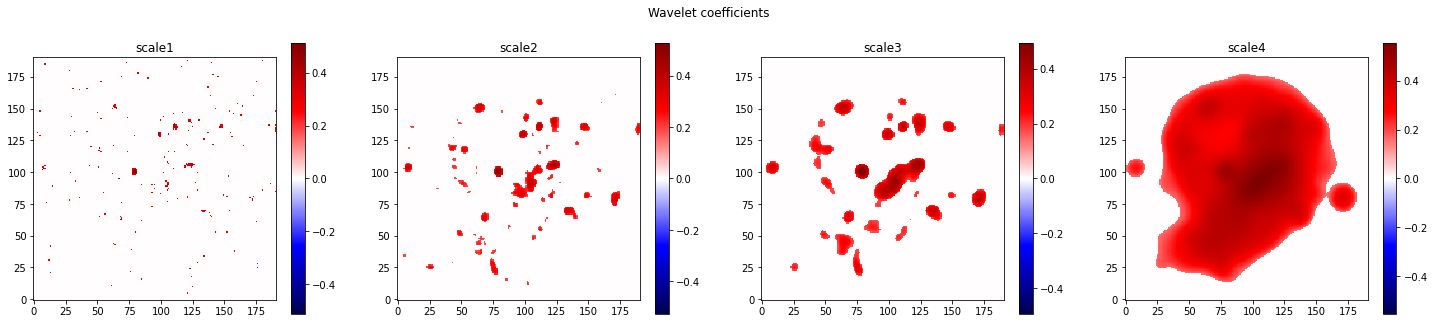

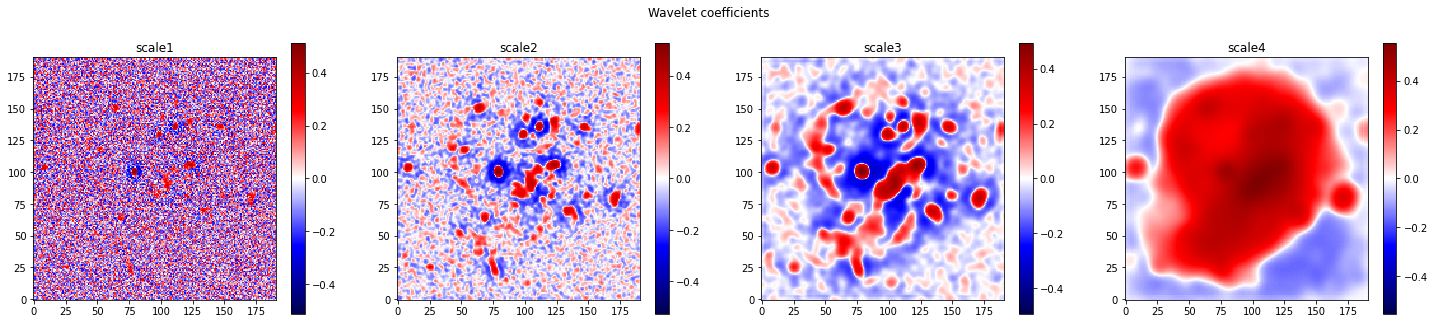

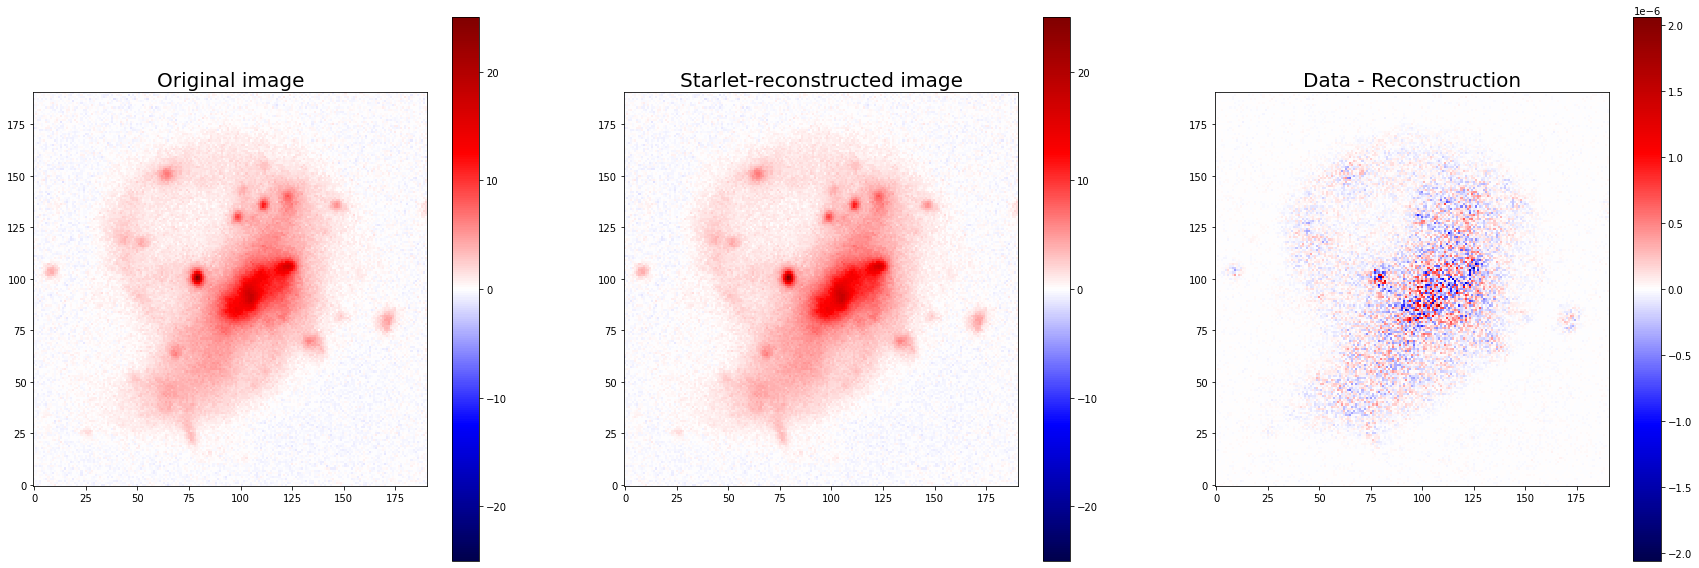

In [5]:
# Display the detection coefficients
lvl = detect.shape[0]
plt.figure(figsize = (lvl*5+5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    img = detect[i]
    img = np.arcsinh(10*img)/10
    vmax = np.max(np.abs(img))
    plt.imshow(img, cmap="seismic", vmin=-vmax, vmax=vmax)
    plt.colorbar()
plt.show()

# Display the detection coefficients
lvl = detect.shape[0]
plt.figure(figsize = (lvl*5+5,5))
plt.suptitle('Wavelet coefficients')
for i in range(lvl):
    plt.subplot(1,lvl,i+1)
    plt.title('scale'+str(i+1))
    img = coeffs[i]
    img = np.arcsinh(10*img)/10
    vmax = np.max(np.abs(img))
    plt.imshow(img, cmap="seismic", vmin=-vmax, vmax=vmax)
    plt.colorbar()
plt.show()

reconstruction = scarlet.wavelet.starlet_reconstruction(coeffs)
residual = detect_image - reconstruction

#Making sure we recover the original image:
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.title('Original image', fontsize = 20)
vmax = np.max(np.abs(detect_image))
plt.imshow(detect_image, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.subplot(132)
plt.title('Starlet-reconstructed image', fontsize = 20)
vmax = np.max(np.abs(reconstruction))
plt.imshow(reconstruction, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.subplot(133)
plt.title('Data - Reconstruction', fontsize = 20)
vmax = np.max(np.abs(residual))
plt.imshow(residual, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

We detect footprints and peaks on the 2nd scale in the `detect` image defined above. Notice that most footprints have a single peak, while a few footprints, like the central region (peaks 15-18), have multiple peaks.

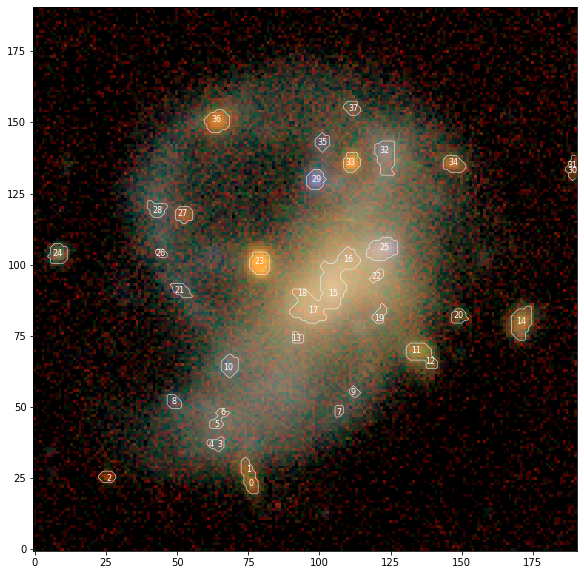

In [6]:
from scarlet.detect_pybind11 import get_footprints

# Calculate isolated footprints and their maxima
# in the 2nd wavelet scale.
footprints = get_footprints(detect[1], min_separation=0, min_area=10, thresh=0)

# Display all of the footprints
footprint_img = np.zeros(detect.shape[1:])
peaks = []
for fp in footprints:
    bbox = scarlet.detect.bounds_to_bbox(fp.bounds)
    footprint_img[bbox.slices] = fp.footprint
    peaks += list(fp.peaks)

# Now display the peaks on the original image
plt.figure(figsize=(10,10))
plt.imshow(img_rgb)
plt.contour(footprint_img, [0.5,], colors='w', linewidths=0.5)
for k, peak in enumerate(peaks):
    plt.text(peak.x, peak.y, str(k), color="w", ha='center', va='center', size=8)
plt.show()

## Model with Starlet Components

The extended diffuse emission wasn't detected as level 2 as a distinct single peak. Instead, we have a collection of many peaks, some of which are likely part of the LSB, but it's hard to tell from a visual inspection.

We'll model every detected peak as `ExtendedSource` and add a `StarletSource` to pick up the diffuse emission. In a second step below, we'll merge source that have very similar color to the diffuse light.

In [7]:
centers = [(peak.y, peak.x) for peak in peaks]
sources, skipped = scarlet.initialization.init_all_sources(model_frame,
                                                           centers,
                                                           observation,
                                                           max_components=1,
                                                           min_snr=50,
                                                           thresh=1,
                                                           fallback=True,
                                                           silent=True,
                                                           set_spectra=False
                                                          )
# Use a random seed to get consistent models in this demo
np.random.seed(0)

sources.append(scarlet.source.StarletSource(model_frame))

No flux in morphology model for source at (133, 189)


No flux in morphology model for source at (135, 189)


### Create and Fit Model
The `Blend` class represents the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

CPU times: user 37.8 s, sys: 1.28 s, total: 39 s
Wall time: 39 s
scarlet ran for 200 iterations to logL = -169688.37993673192


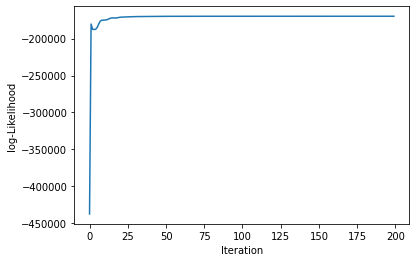

In [8]:
blend = scarlet.Blend(sources, observation)
%time it, logL = blend.fit(200, e_rel=1e-6)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(blend)
plt.show()

### View Full Scene

We use `scarlet.display.show_scene` to render the entire scene. It shows model and data with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

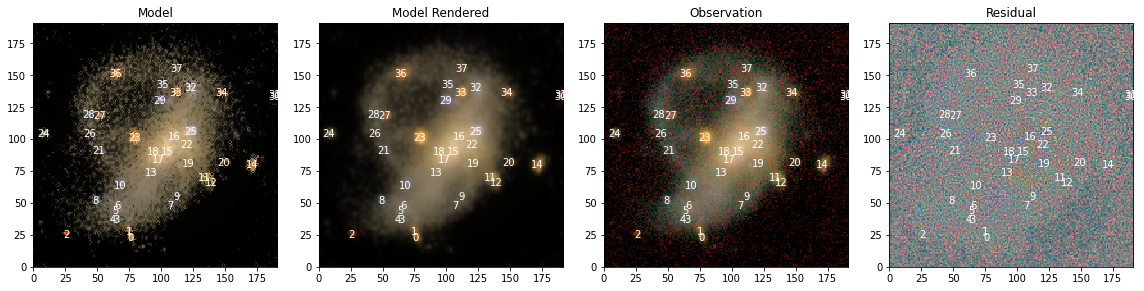

In [9]:
scarlet.display.show_scene(sources, 
                           norm=norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True,
                          )
plt.show()

### View Source Models

We now inspect the model for each source, in its original frame and in its observed frame by leveraging the `show_sources` method:

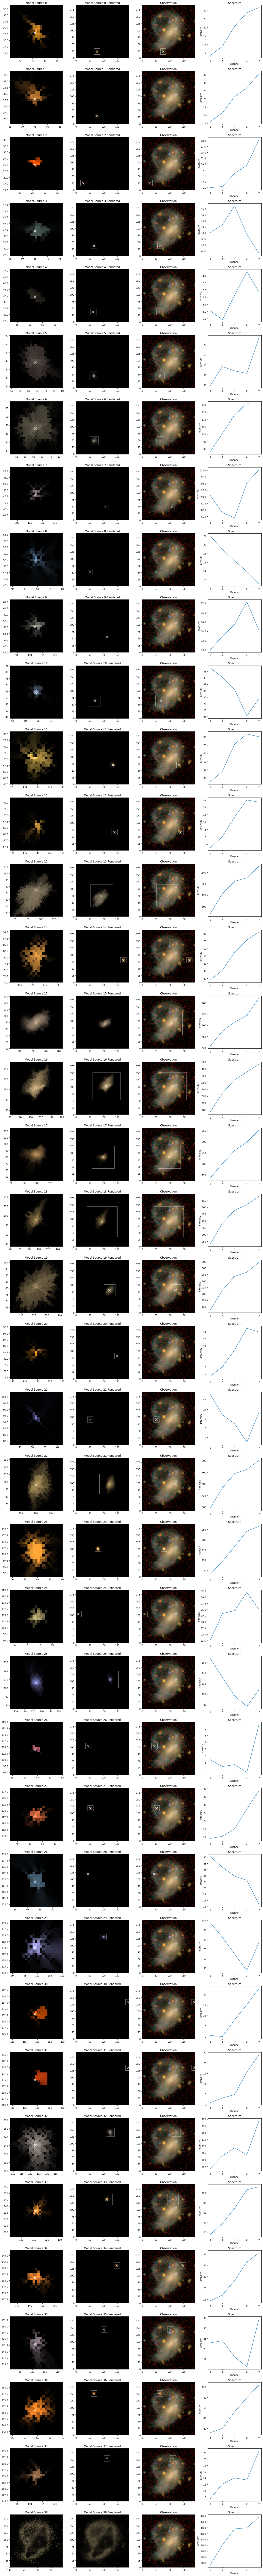

In [10]:
scarlet.display.show_sources(sources, 
                             norm=norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True,
                             add_boxes=True
                            )
plt.show()

### Subtracting the LSBG components

Inspecting the source models above we see that the `StarletSource` indeed picked up a lot of the diffuse emission, but that several other sources have very similar spectrum to the LSB. We'll find them and combine their models to form what we think is the entire LSB galaxy, peaks as well as diffuse emission:

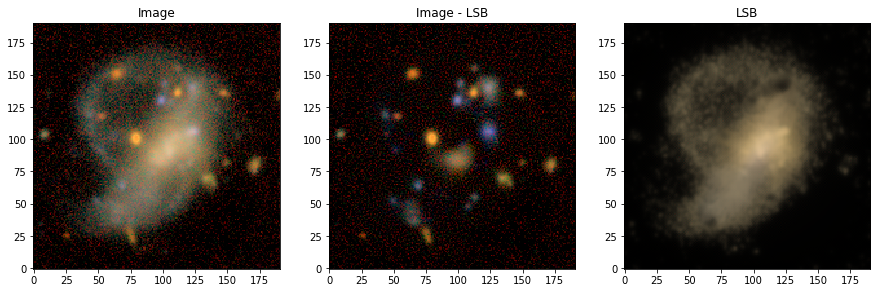

In [11]:
# find all sources with very similar colors to the Starlet source of the diffuse emission
spectrum = sources[-1].spectrum
C = np.zeros(len(sources))
for j, src in enumerate(sources):
    spectrum_ = src.spectrum
    # cosine similarity
    C[j] = spectrum @ spectrum_ / np.sqrt(spectrum @ spectrum) / np.sqrt(spectrum_ @ spectrum_)

lsbg = sum( sources[j].get_model(frame=model_frame) for j in range(len(sources)) if C[j] > 0.995 )
model = blend.get_model() - lsbg
lsbg = observation.render(lsbg)

res_rgb = scarlet.display.img_to_rgb(images-lsbg, norm=norm)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=norm)
model_rgb = scarlet.display.img_to_rgb(images-model, norm=norm)

plt.figure(figsize = (15,5))
plt.subplot(131)
plt.title("Image")
plt.imshow(img_rgb)

plt.subplot(132)
plt.imshow(res_rgb)
plt.title("Image - LSB")

plt.subplot(133)
plt.imshow(lsbg_rgb)
plt.title("LSB")

plt.show()